# Simple audio recognition: Recognizing keywords

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
import utils
from utils.audio_utils import *
from utils.audio_models import *
from utils.keras_utils import *

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


## Speech dataset (2.11 GB uncompressed)
#### http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

# Speech dataset (2.11 GB uncompressed)
# http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# if not data_dir.exists():
#     tf.keras.utils.get_file(
#     'mini_speech_commands.zip',
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
#     extract=True,
#     cache_dir='.', cache_subdir='data')

# Experiment with different audio features

#### MFCC • A highly engineered preprocessing of the audio waveform

MFCC computation involves 6 steps

1. Segment the signal into short frames
2. For each frame: calculate its power spectrum
3. Apply a Mel filterbank to the power spectrum
    • sum the energy within each filter.
    

    We take clumps of periodogram bins and sum them up to get an
    idea of how much energy there exists in each region
    • This is performed using a Mel filterbank
    • First Mel filter is very narrow: to get an idea of how much energy there
    is around 0 Hertz
    • Filters get wider as frequencies get higher: we become less
    concerned about variations (Mel scale tells us how to space filterbanks)
4. Take the logarithm of all filterbank energies
5. Take the DCT of the log filterbank energies - DCT decorrelates filterbank energies
6. Keep DCT coefficients 2-13, discard the others

## File signal example and feature vector calculation

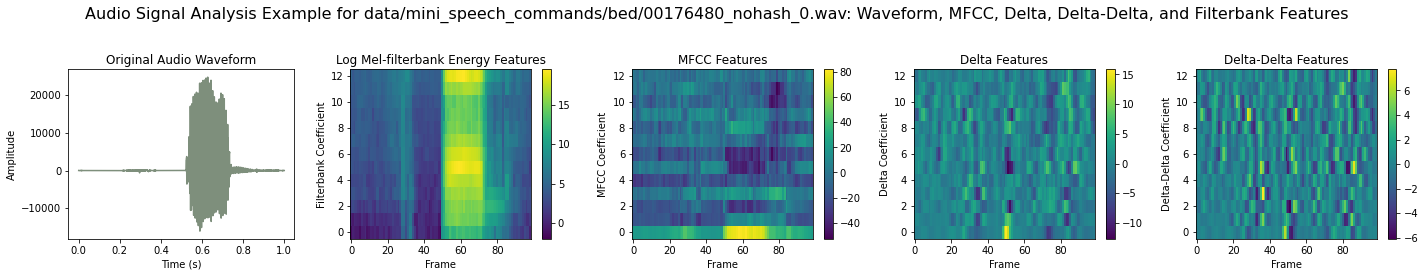

In [3]:
# Load an example audio file for inference
data_dir = 'data/mini_speech_commands/bed/'
file = '00176480_nohash_0.wav'
file_path = os.path.join(data_dir, file)
rate, example_signal = wavfile.read(file_path)

sig_ds, rate_ds, feature_dicts = example_feature_vectors(file_path, 1)

# Separate dictionaries for each feature type
signal_dict = feature_dicts['signal_dict']
mfcc_dict = feature_dicts['mfcc_dict']
delta_dict = feature_dicts['delta_dict']
delta_delta_dict = feature_dicts['delta_delta_dict']
fbank_dict = feature_dicts['fbank_dict']
full_feature_vector_dict = feature_dicts['full_feature_vector_dict']

plot_example(sig_ds, rate_ds, fbank_dict,mfcc_dict, delta_dict, delta_delta_dict, file_path)

## Calculate the feature vectors of words

In [4]:
# Load the feature vectors from the saved pickle file
load_path = 'feature_data/ten_words.pkl'
with open(load_path, 'rb') as file:
    signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds = pickle.load(file)


In [5]:
# Convert each dictionary value from list to array
convert_to_arrays(signal_ds)
convert_to_arrays(spectro_ds)
convert_to_arrays(mfcc_ds)
convert_to_arrays(delta_ds)
convert_to_arrays(delta_delta_ds)
convert_to_arrays(full_feature_vector_ds)

# Add channel axis, N, 99, 13, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(signal_ds)
add_new_axis(spectro_ds)
add_new_axis(mfcc_ds)
add_new_axis(delta_ds)
add_new_axis(delta_delta_ds)
# Add channel axis, N, 99, 43, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(full_feature_vector_ds)

# Investigate recent/new ANN architectures

### Inception

In [6]:
# Split in train and test
X_train, X_test, y_train, y_test, sig_train, sig_test, one_hot_labels, one_hot_encoder, y_decoded_train, y_decoded_test = train_test_creation(mfcc_ds, signal_ds)

# Specify the amount of padding for each dimension
pad_width = ((0, 0), (0, 1), (44, 43), (0, 0))

# Pad the array with zeros
X_train = np.pad(X_train, pad_width, mode='constant', constant_values=0)
X_test = np.pad(X_test, pad_width, mode='constant', constant_values=0)

# Perform data augmentation
X_train_augmented = augment_data(X_train, augmentation_percentage=0.2)

# Normalize the data, cache it and batch it
train_dataset, test_dataset, img_shape = normalize_cache_batch(X_train_augmented, X_test, y_train, y_test, cache_batch=True)

# Analyze example audio file from X_train

In [7]:
import numpy as np
import sounddevice as sd

# Assuming audio_array is an array of dtype=object containing audio data
audio_array = sig_train[0]  # Replace sig_train[2] with your audio data

# Convert audio_array to a numpy array of type int16
audio_array = np.array(audio_array[0], dtype=np.int16)

# Play audio
sd.play(audio_array, samplerate=16000)
sd.wait()  # Wait until playback is finished

Y_pred_decoded_labels_inc = one_hot_encoder.inverse_transform(y_train[0].reshape(1, -1))

print("OneHotEncoded:", y_train[0])
print("Decoded:", Y_pred_decoded_labels_inc)

OneHotEncoded: [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Decoded: [['eight']]


In [8]:
print('TRAIN SET, images: {}'.format(X_train_augmented.shape))
print('TRAIN SET, labels: {}'.format(y_train.shape))
train_length = y_train.shape[0]

print('TEST SET, images: {}'.format(X_test.shape))
print('TEST SET, labels: {}'.format(y_test.shape))
test_length = y_test.shape[0]

TRAIN SET, images: (11340, 100, 100, 1)
TRAIN SET, labels: (11340, 9)
TEST SET, images: (2835, 100, 100, 1)
TEST SET, labels: (2835, 9)


## Show some examples

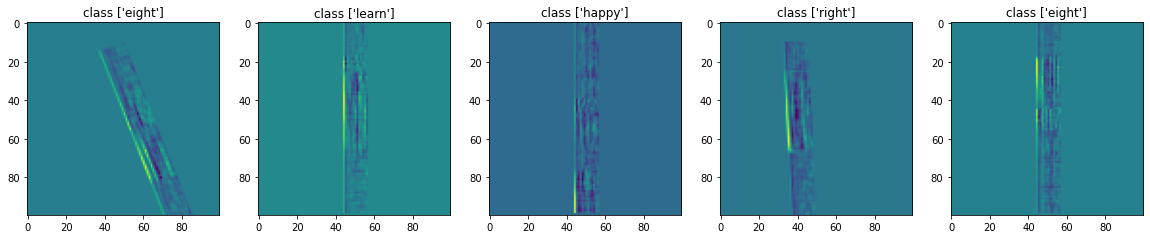

In [9]:
plt.figure(figsize=[20, 4])
plt.subplot(1, 10, 1)

for i in range(5):
    plt.subplot(1, 5, i + 1, label="Subplot {}".format(i + 1))
    image = X_train_augmented[i, :, :, :]
    plt.imshow(image.tolist())
    label = y_decoded_train[i]
    plt.title('class ' + str(label))

plt.show()

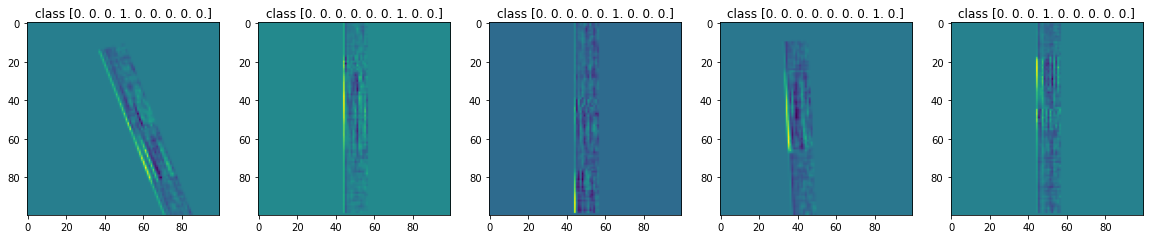

In [10]:
plt.figure(figsize=[20, 4])
plt.subplot(1, 10, 1)

for i in range(5):
    plt.subplot(1, 5, i + 1, label="Subplot {}".format(i + 1))
    image = X_train_augmented[i, :, :, :]
    plt.imshow(image.tolist())
    label = y_train[i]
    plt.title('class ' + str(label))

plt.show()

## [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) that generates batches of tensor image data.

In [11]:
datagen_train = ImageDataGenerator()

In [12]:
datagen_test = ImageDataGenerator()

In [13]:
batch_size = 32
train_steps = int(np.ceil(train_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

# Inception network

In a pure Inception network, there are two different block types: the Inception blocks and the Reduction blocks.

Inception-v4 is composed of three Inception blocks, two Reduction ones and an initial stem block.

## 1 - Inception-v4 blocks
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``conv2d_bn`` helper function that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$).
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function.

In [14]:
# FUNCTION: conv2d_bn block

def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    """
    Implementation of a conv block as defined above

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    s -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers

    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides,
               padding = padding, name = conv_name_base + name,
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
    return X

## 1.2 - The stem block

In [15]:
# FUNCTION: stem_block

def stem_block(X_input):
    """
    Implementation of the stem block as defined above

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the stem block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # First conv
    X = conv2d_bn(X_input, filters = 32, kernel_size = (3, 3), strides = (2, 2),
                  padding = 'valid', activation='relu', name = 'stem_1th')

    # Second conv
    X = conv2d_bn(X, filters = 32, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'valid', activation='relu', name = 'stem_2nd')

    # Third conv
    X = conv2d_bn(X, filters = 64, kernel_size = (3, 3), strides = (1, 1),
                  padding = 'same', activation='relu', name =  'stem_3rd')

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_1stbranch_1')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters = 96, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_1stbranch_2')

    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_1_1')
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_1_2')

    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_1')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_2')
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'stem_2ndbranch_2_3')
    branch2 = conv2d_bn(branch2, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'valid', activation='relu',
                        name = 'stem_2ndbranch_2_4')

    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: conv
    branch1 = conv2d_bn(X, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'stem_3rdbranch_1')

    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_3rdbranch_2')(X)

    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    ### END CODE HERE ###

    return X

## 1.3 - The Inception-A block

In [16]:
# FUNCTION: Inception-A block

def inception_a_block(X_input, base_name):
    """
    Implementation of the Inception-A block

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ia_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 96, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_3_2')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 64, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 96, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ia_branch_4_3')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    ### END CODE HERE ###

    return X

# FUNCTION: Inception-B block

def inception_b_block(X_input, base_name):
    """
    Implementation of the Inception-B block

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ib_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 128, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 192, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_3')
    branch4 = conv2d_bn(branch4, filters = 224, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_4')
    branch4 = conv2d_bn(branch4, filters = 256, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ib_branch_4_5')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)

    ### END CODE HERE ###

    return X

# FUNCTION: Inception-C block

def inception_c_block(X_input, base_name):
    """
    Implementation of the Inception-C block

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1),
                           padding = 'same', name = base_name + 'ic_branch_1_1')(X_input)
    branch1 = conv2d_bn(branch1, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_1_2')

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_1')
    branch3_1 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_2')
    branch3_2 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_3_3')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 384, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 448, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 512, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_3')
    branch4_1 = conv2d_bn(branch4, filters = 256, kernel_size = (3, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_4')
    branch4_2 = conv2d_bn(branch4, filters = 256, kernel_size = (1, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = base_name + 'ic_branch_4_5')

    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3_1, branch3_2, branch4_1,
                          branch4_2], axis=3)

    ### END CODE HERE ###

    return X

## 1.4 - The Reduction-A block

In [17]:
# FUNCTION: Reduction-A block

def reduction_a_block(X_input):
    """
    Implementation of the Reduction-A block

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'ra_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_2_1')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 224, kernel_size = (3, 3),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'ra_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'ra_branch_3_3')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    ### END CODE HERE ###

    return X

# FUNCTION: Reduction-B block

def reduction_b_block(X_input):
    """
    Implementation of the Reduction-B block

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'rb_branch_1_1')(X_input)

    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_2_1')
    branch2 = conv2d_bn(branch2, filters = 192, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_2_2')

    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (1, 7),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (7, 1),
                        strides = (1, 1), padding = 'same', activation='relu',
                        name = 'rb_branch_3_3')
    branch3 = conv2d_bn(branch3, filters = 320, kernel_size = (3, 3),
                        strides = (2, 2), padding = 'valid', activation='relu',
                        name = 'rb_branch_3_4')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)

    ### END CODE HERE ###

    return X

## 1.5 - Network construction

Inception-v4 network

Add a ``Flatten`` layer after the last ``AveragePooling2D`` layer.

In [20]:
# FUNCTION: Inception-v4

def Inceptionv4(input_shape,num_classes,activation_function):
    """
    Implementation of the Inception-v4 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    ### START CODE HERE ###

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, 'a1')
    X = inception_a_block(X, 'a2')
    X = inception_a_block(X, 'a3')
    X = inception_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, 'b1')
    X = inception_b_block(X, 'b2')
    X = inception_b_block(X, 'b3')
    X = inception_b_block(X, 'b4')
    X = inception_b_block(X, 'b5')
    X = inception_b_block(X, 'b6')
    X = inception_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, 'c1')
    X = inception_c_block(X, 'c2')
    X = inception_c_block(X, 'c3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(rate = 0.2)(X)

    # Output layer
    X = Dense(num_classes, activation=activation_function, name='fc')(X)

    ### END CODE HERE ###

    # Create model
    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model

## 2 - Network training

In [21]:
num_labels = len(one_hot_labels)
activation_function = 'softmax'
loss_multi = 'categorical_crossentropy'

model = Inceptionv4(input_shape = (100, 100, 1), num_classes = num_labels, activation_function = activation_function)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)

In [23]:
# Create a callback for early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

# Assuming `model` is already defined elsewhere

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Assuming you have defined `datagen_train`, `datagen_test`, `X_train`, `Y_train`, `X_test`, `Y_test`, `batch_size`, `train_steps`, and `test_steps` elsewhere

train_dataset = datagen_train.flow(X_train_augmented, y_train, batch_size=batch_size, shuffle=True)
test_dataset = datagen_test.flow(X_test, y_test, batch_size=batch_size, shuffle=True)

# Train the model with early stopping callback
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=20,
          steps_per_epoch=train_steps,
          validation_steps=test_steps,
          callbacks=[early_stopping_callback])

Model: "Inceptionv4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 conv_stem_1th (Conv2D)      (None, 49, 49, 32)           320       ['input_1[0][0]']             
                                                                                                  
 bn_stem_1th (BatchNormaliz  (None, 49, 49, 32)           128       ['conv_stem_1th[0][0]']       
 ation)                                                                                           
                                                                                                  
 activation (Activation)     (None, 49, 49, 32)           0         ['bn_stem_1th[0][0]'

 chNormalization)                                                   ]']                           
                                                                                                  
 bn_stem_2ndbranch_2_4 (Bat  (None, 21, 21, 96)           384       ['conv_stem_2ndbranch_2_4[0][0
 chNormalization)                                                   ]']                           
                                                                                                  
 activation_5 (Activation)   (None, 21, 21, 96)           0         ['bn_stem_2ndbranch_1_2[0][0]'
                                                                    ]                             
                                                                                                  
 activation_9 (Activation)   (None, 21, 21, 96)           0         ['bn_stem_2ndbranch_2_4[0][0]'
                                                                    ]                             
          

 activation_14 (Activation)  (None, 10, 10, 96)           0         ['bn_a1ia_branch_3_2[0][0]']  
                                                                                                  
 activation_17 (Activation)  (None, 10, 10, 96)           0         ['bn_a1ia_branch_4_3[0][0]']  
                                                                                                  
 tf.concat_3 (TFOpLambda)    (None, 10, 10, 384)          0         ['activation_11[0][0]',       
                                                                     'activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]']       
                                                                                                  
 conv_a2ia_branch_4_1 (Conv  (None, 10, 10, 64)           24640     ['tf.concat_3[0][0]']         
 2D)      

                                                                                                  
 conv_a3ia_branch_4_2 (Conv  (None, 10, 10, 96)           55392     ['activation_29[0][0]']       
 2D)                                                                                              
                                                                                                  
 bn_a3ia_branch_3_1 (BatchN  (None, 10, 10, 64)           256       ['conv_a3ia_branch_3_1[0][0]']
 ormalization)                                                                                    
                                                                                                  
 bn_a3ia_branch_4_2 (BatchN  (None, 10, 10, 96)           384       ['conv_a3ia_branch_4_2[0][0]']
 ormalization)                                                                                    
                                                                                                  
 a3ia_bran

                                                                                                  
 conv_a4ia_branch_2_1 (Conv  (None, 10, 10, 96)           36960     ['tf.concat_5[0][0]']         
 2D)                                                                                              
                                                                                                  
 conv_a4ia_branch_3_2 (Conv  (None, 10, 10, 96)           55392     ['activation_34[0][0]']       
 2D)                                                                                              
                                                                                                  
 conv_a4ia_branch_4_3 (Conv  (None, 10, 10, 96)           83040     ['activation_37[0][0]']       
 2D)                                                                                              
                                                                                                  
 bn_a4ia_b

 2D)                                                                                              
                                                                                                  
 bn_b1ib_branch_4_2 (BatchN  (None, 4, 4, 192)            768       ['conv_b1ib_branch_4_2[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)  (None, 4, 4, 192)            0         ['bn_b1ib_branch_4_2[0][0]']  
                                                                                                  
 conv_b1ib_branch_3_1 (Conv  (None, 4, 4, 192)            196800    ['tf.concat_7[0][0]']         
 2D)                                                                                              
                                                                                                  
 conv_b1ib

 ormalization)                                                                                    
                                                                                                  
 activation_58 (Activation)  (None, 4, 4, 192)            0         ['bn_b2ib_branch_4_1[0][0]']  
                                                                                                  
 conv_b2ib_branch_4_2 (Conv  (None, 4, 4, 192)            258240    ['activation_58[0][0]']       
 2D)                                                                                              
                                                                                                  
 bn_b2ib_branch_4_2 (BatchN  (None, 4, 4, 192)            768       ['conv_b2ib_branch_4_2[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv_b3ib_branch_4_1 (Conv  (None, 4, 4, 192)            196800    ['tf.concat_9[0][0]']         
 2D)                                                                                              
                                                                                                  
 bn_b3ib_branch_4_1 (BatchN  (None, 4, 4, 192)            768       ['conv_b3ib_branch_4_1[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activation_68 (Activation)  (None, 4, 4, 192)            0         ['bn_b3ib_branch_4_1[0][0]']  
                                                                                                  
 conv_b3ib_branch_4_2 (Conv  (None, 4, 4, 192)            258240    ['activation_68[0][0]']       
 2D)      

                                                                                                  
 tf.concat_10 (TFOpLambda)   (None, 4, 4, 1024)           0         ['activation_63[0][0]',       
                                                                     'activation_64[0][0]',       
                                                                     'activation_67[0][0]',       
                                                                     'activation_72[0][0]']       
                                                                                                  
 conv_b4ib_branch_4_1 (Conv  (None, 4, 4, 192)            196800    ['tf.concat_10[0][0]']        
 2D)                                                                                              
                                                                                                  
 bn_b4ib_branch_4_1 (BatchN  (None, 4, 4, 192)            768       ['conv_b4ib_branch_4_1[0][0]']
 ormalizat

 activation_74 (Activation)  (None, 4, 4, 384)            0         ['bn_b4ib_branch_2_1[0][0]']  
                                                                                                  
 activation_77 (Activation)  (None, 4, 4, 256)            0         ['bn_b4ib_branch_3_3[0][0]']  
                                                                                                  
 activation_82 (Activation)  (None, 4, 4, 256)            0         ['bn_b4ib_branch_4_5[0][0]']  
                                                                                                  
 tf.concat_11 (TFOpLambda)   (None, 4, 4, 1024)           0         ['activation_73[0][0]',       
                                                                     'activation_74[0][0]',       
                                                                     'activation_77[0][0]',       
                                                                     'activation_82[0][0]']       
          

 bn_b5ib_branch_4_5 (BatchN  (None, 4, 4, 256)            1024      ['conv_b5ib_branch_4_5[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)  (None, 4, 4, 128)            0         ['bn_b5ib_branch_1_2[0][0]']  
                                                                                                  
 activation_84 (Activation)  (None, 4, 4, 384)            0         ['bn_b5ib_branch_2_1[0][0]']  
                                                                                                  
 activation_87 (Activation)  (None, 4, 4, 256)            0         ['bn_b5ib_branch_3_3[0][0]']  
                                                                                                  
 activation_92 (Activation)  (None, 4, 4, 256)            0         ['bn_b5ib_branch_4_5[0][0]']  
          

                                                                                                  
 bn_b6ib_branch_2_1 (BatchN  (None, 4, 4, 384)            1536      ['conv_b6ib_branch_2_1[0][0]']
 ormalization)                                                                                    
                                                                                                  
 bn_b6ib_branch_3_3 (BatchN  (None, 4, 4, 256)            1024      ['conv_b6ib_branch_3_3[0][0]']
 ormalization)                                                                                    
                                                                                                  
 bn_b6ib_branch_4_5 (BatchN  (None, 4, 4, 256)            1024      ['conv_b6ib_branch_4_5[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv_b7ib_branch_2_1 (Conv  (None, 4, 4, 384)            393600    ['tf.concat_13[0][0]']        
 2D)                                                                                              
                                                                                                  
 conv_b7ib_branch_3_3 (Conv  (None, 4, 4, 256)            401664    ['activation_106[0][0]']      
 2D)                                                                                              
                                                                                                  
 conv_b7ib_branch_4_5 (Conv  (None, 4, 4, 256)            401664    ['activation_111[0][0]']      
 2D)                                                                                              
                                                                                                  
 bn_b7ib_b

                                                                                                  
 bn_rb_branch_3_4 (BatchNor  (None, 1, 1, 320)            1280      ['conv_rb_branch_3_4[0][0]']  
 malization)                                                                                      
                                                                                                  
 rb_branch_1_1 (MaxPooling2  (None, 1, 1, 1024)           0         ['tf.concat_14[0][0]']        
 D)                                                                                               
                                                                                                  
 activation_114 (Activation  (None, 1, 1, 192)            0         ['bn_rb_branch_2_2[0][0]']    
 )                                                                                                
                                                                                                  
 activatio

 bn_c1ic_branch_3_3 (BatchN  (None, 1, 1, 256)            1024      ['conv_c1ic_branch_3_3[0][0]']
 ormalization)                                                                                    
                                                                                                  
 bn_c1ic_branch_4_4 (BatchN  (None, 1, 1, 256)            1024      ['conv_c1ic_branch_4_4[0][0]']
 ormalization)                                                                                    
                                                                                                  
 bn_c1ic_branch_4_5 (BatchN  (None, 1, 1, 256)            1024      ['conv_c1ic_branch_4_5[0][0]']
 ormalization)                                                                                    
                                                                                                  
 activation_119 (Activation  (None, 1, 1, 256)            0         ['bn_c1ic_branch_1_2[0][0]']  
 )        

 2D)                                                                                              
                                                                                                  
 conv_c2ic_branch_4_4 (Conv  (None, 1, 1, 256)            393472    ['activation_136[0][0]']      
 2D)                                                                                              
                                                                                                  
 conv_c2ic_branch_4_5 (Conv  (None, 1, 1, 256)            393472    ['activation_136[0][0]']      
 2D)                                                                                              
                                                                                                  
 bn_c2ic_branch_1_2 (BatchN  (None, 1, 1, 256)            1024      ['conv_c2ic_branch_1_2[0][0]']
 ormalization)                                                                                    
          

                                                                                                  
 activation_141 (Activation  (None, 1, 1, 384)            0         ['bn_c3ic_branch_3_1[0][0]']  
 )                                                                                                
                                                                                                  
 activation_146 (Activation  (None, 1, 1, 512)            0         ['bn_c3ic_branch_4_3[0][0]']  
 )                                                                                                
                                                                                                  
 conv_c3ic_branch_1_2 (Conv  (None, 1, 1, 256)            393472    ['c3ic_branch_1_1[0][0]']     
 2D)                                                                                              
                                                                                                  
 conv_c3ic

Epoch 3/20
355/355 [==============================] - 635s 2s/step - loss: 1.5784 - accuracy: 0.4614 - val_loss: 1.7396 - val_accuracy: 0.4649
Epoch 4/20
355/355 [==============================] - 650s 2s/step - loss: 1.3494 - accuracy: 0.5550 - val_loss: 0.9980 - val_accuracy: 0.6543
Epoch 5/20
355/355 [==============================] - 685s 2s/step - loss: 1.0970 - accuracy: 0.6412 - val_loss: 24.3713 - val_accuracy: 0.3965
Epoch 6/20
355/355 [==============================] - 732s 2s/step - loss: 1.1093 - accuracy: 0.6352 - val_loss: 1.2461 - val_accuracy: 0.6187
Epoch 7/20
355/355 [==============================] - 728s 2s/step - loss: 0.8984 - accuracy: 0.7123 - val_loss: 0.5663 - val_accuracy: 0.8145
Epoch 8/20
355/355 [==============================] - 635s 2s/step - loss: 0.7907 - accuracy: 0.7444 - val_loss: 5.3289 - val_accuracy: 0.4138
Epoch 9/20
355/355 [==============================] - 857s 2s/step - loss: 0.9592 - accuracy: 0.6922 - val_loss: 0.5028 - val_accuracy: 0.836

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print('Test Loss = {:.5f}'.format(test_loss))
print('Test Accuracy = {:.2f}%'.format(test_accuracy * 100))


In [ ]:
X_test = X_test.astype('float32')  # Convert to float32

# Make predictions on the test set
y_pred = model.predict(X_test)

# Decode one-hot encoded labels
y_pred_decoded_labels = one_hot_encoder.inverse_transform(y_pred)
y_test_decoded_labels = one_hot_encoder.inverse_transform(y_test)

# Get unique labels for setting tick labels
labels = np.unique(np.concatenate((y_test_decoded_labels, y_pred_decoded_labels)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_decoded_labels, y_pred_decoded_labels)

# Normalize confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with annotated values
plt.figure(figsize=(10, 8))  # Larger plot size
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Set tick labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add annotations
thresh = conf_matrix_normalized.max() / 2.  # Threshold for text color
for i in range(conf_matrix_normalized.shape[0]):
    for j in range(conf_matrix_normalized.shape[1]):
        plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if conf_matrix_normalized[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
class_report = classification_report(y_test_decoded_labels, y_pred_decoded_labels)
print("Classification Report:\n", class_report)

# Memory Allocation and Usage
process = psutil.Process(os.getpid())
print(f"Memory Allocation: {process.memory_info().rss / (1024 ** 2):.2f} MB")
print(f"Memory Usage: {psutil.virtual_memory().percent:.2f}")

In [ ]:
# Save the trained model in the recommended format
model.save('models/Inception/Inception_v4_model.keras')

# Save the label encoder
joblib.dump(one_hot_encoder, 'models/Inception/label_encoder_Inception_v4.pkl')